<a href="https://colab.research.google.com/github/Biruk-gebru/Diffusion-Model/blob/main/DiffusionModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Install if not already present
!pip install torch torchvision matplotlib tqdm

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import math
import random


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 65.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 482kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.47MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.98MB/s]


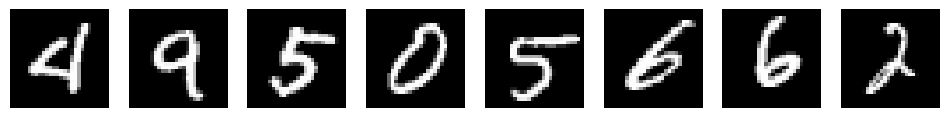

In [3]:
# Transform to [0, 1] and flatten to tensors
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts to [0,1]
])

train_data = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)

# Visual check
examples = next(iter(train_loader))[0][:8]
fig, axs = plt.subplots(1, 8, figsize=(12, 2))
for i in range(8):
    axs[i].imshow(examples[i][0], cmap='gray')
    axs[i].axis('off')
plt.show()


In [15]:
#SCHEDULER_LINEAR

def linear_beta_schedule(timesteps, beta_start=1e-4, beta_end=0.02):
    return torch.linspace(beta_start, beta_end, timesteps)

T = 300  # Total timesteps
betas_linear = linear_beta_schedule(T)
alphas_linear = 1. - betas_linear
alpha_hats_linear = torch.cumprod(alphas_linear, dim=0).to(device)


In [16]:
#SCHEDULER_COSINE

def cosine_beta_schedule(timesteps, s=0.008):
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * math.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

betas_cosine = cosine_beta_schedule(T)
alphas_cosine = 1. - betas_cosine
alpha_hats_cosine = torch.cumprod(alphas_cosine, dim=0).to(device)


In [17]:
#SCHEDULER_EXPONENTIAL

def exponential_beta_schedule(timesteps, base=1.02, beta_start=1e-4):
    return beta_start * (base ** torch.arange(timesteps))

betas_exp = exponential_beta_schedule(T)
alphas_exp = 1. - betas_exp
alpha_hats_exp = torch.cumprod(alphas_exp, dim=0).to(device)


In [18]:
#SCHEDULER_SELECTOR

def get_schedule(name):
    if name == "linear":
        return betas_linear.to(device), alphas_linear.to(device), alpha_hats_linear.to(device)
    elif name == "cosine":
        return betas_cosine.to(device), alphas_cosine.to(device), alpha_hats_cosine.to(device)
    elif name == "exponential":
        return betas_exp.to(device), alphas_exp.to(device), alpha_hats_exp.to(device)
    else:
        raise ValueError("Unknown scheduler type.")

SCHEDULER_TYPE = "linear"  # choose: "linear", "cosine", "exponential"
betas, alphas, alpha_hats = get_schedule(SCHEDULER_TYPE)


In [21]:
#TIME_EMBEDDING

class SinusoidalTimeEmbedding(nn.Module):
    def __init__(self, embedding_dim):
        super().__init__()
        self.embedding_dim = embedding_dim

        self.linear1 = nn.Linear(embedding_dim, embedding_dim)
        self.act = nn.ReLU()
        self.linear2 = nn.Linear(embedding_dim, embedding_dim)

    def forward(self, t):
        device = t.device
        half_dim = self.embedding_dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = t[:, None] * emb[None, :]  # Shape: [batch_size, half_dim]
        emb = torch.cat((torch.sin(emb), torch.cos(emb)), dim=-1)  # [batch_size, embedding_dim]
        emb = self.linear1(emb)
        emb = self.act(emb)
        emb = self.linear2(emb)
        return emb  # Shape: [batch_size, embedding_dim]


In [22]:
#LABEL_EMBEDDING

class LabelEmbedding(nn.Module):
    def __init__(self, num_classes=10, embed_dim=28 * 28):
        super().__init__()
        self.embed = nn.Embedding(num_classes, embed_dim)

    def forward(self, labels):
        out = self.embed(labels)  # [batch_size, 784]
        return out.view(-1, 1, 28, 28)  # Reshape to image shape


In [23]:
#UNET_BACKBONE

class ConditionalUNet(nn.Module):
    def __init__(self, time_embed_dim=128):
        super().__init__()
        self.time_mlp = SinusoidalTimeEmbedding(time_embed_dim)

        # Project time embedding to feature map shape
        self.time_proj = nn.Sequential(
            nn.Linear(time_embed_dim, 28 * 28),
            nn.ReLU()
        )

        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)  # 1 (image) + 1 (label) + 1 (time)
        self.norm1 = nn.GroupNorm(8, 64)

        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.norm2 = nn.GroupNorm(8, 64)

        self.conv3 = nn.Conv2d(64, 1, 3, padding=1)

    def forward(self, x, t, label_embed):
        time_embed = self.time_mlp(t)  # [batch, time_embed_dim]
        time_embed = self.time_proj(time_embed).view(-1, 1, 28, 28)

        x = torch.cat([x, time_embed, label_embed], dim=1)  # [B, 3, 28, 28]

        x = self.conv1(x)
        x = self.norm1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = self.norm2(x)
        x = F.relu(x)

        return self.conv3(x)


In [24]:
#FORWARD_DIFFUSION

def add_noise(x0, t, alpha_hats, noise=None):
    if noise is None:
        noise = torch.randn_like(x0)

    # Ensure alpha_hats is on same device
    sqrt_alpha_hat = alpha_hats[t].view(-1, 1, 1, 1).sqrt()
    sqrt_one_minus_alpha_hat = (1 - alpha_hats[t]).view(-1, 1, 1, 1).sqrt()

    return sqrt_alpha_hat * x0 + sqrt_one_minus_alpha_hat * noise, noise


In [25]:
#REVERSE_DENOISING

@torch.no_grad()
def sample(model, label, alpha_hats, alphas, betas, steps=T):
    model.eval()
    img = torch.randn((1, 1, 28, 28), device=device)
    label_tensor = torch.tensor([label], device=device)
    label_embed = label_embedding(label_tensor)

    for t in reversed(range(steps)):
        t_tensor = torch.tensor([t], device=device)
        pred_noise = model(img, t_tensor, label_embed)

        alpha = alphas[t]
        alpha_hat = alpha_hats[t]
        beta = betas[t]

        # Remove predicted noise
        img = (1 / alpha.sqrt()) * (img - ((1 - alpha).sqrt()) * pred_noise)

        # Add noise for next step (except t = 0)
        if t > 0:
            noise = torch.randn_like(img)
            img += beta.sqrt() * noise

    return img


In [26]:
#TRAIN_LOOP
device = "cuda" if torch.cuda.is_available() else "cpu"
# Initialize everything
time_embedding = SinusoidalTimeEmbedding(128).to(device)
label_embedding = LabelEmbedding().to(device)
model = ConditionalUNet().to(device)

optimizer = torch.optim.Adam(
    list(model.parameters()) + list(label_embedding.parameters()),
    lr=1e-3
)

# Training loop
EPOCHS = 5
model.train()
for epoch in range(EPOCHS):
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}")
    for x0, labels in pbar:
        x0 = x0.to(device)
        labels = labels.to(device)
        t = torch.randint(0, T, (x0.size(0),), device=device).long()

        # Forward process: add noise
        x_noisy, noise = add_noise(x0, t, alpha_hats)
        label_embed = label_embedding(labels)

        # Predict the noise
        pred_noise = model(x_noisy, t, label_embed)

        # Loss = predicted vs. actual noise
        loss = F.mse_loss(pred_noise, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.set_postfix(loss=loss.item())


Epoch 0:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/469 [00:00<?, ?it/s]

Enter a digit (0–9) to generate: 1


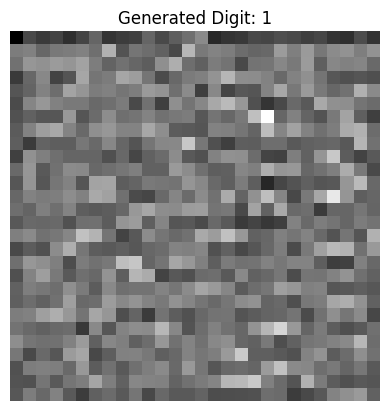

In [27]:
#SAMPLE_GENERATION

def generate_from_prompt(model):
    try:
        label = int(input("Enter a digit (0–9) to generate: "))
        assert 0 <= label <= 9
    except (ValueError, AssertionError):
        print("Invalid input. Please enter a digit between 0 and 9.")
        return

    img = sample(model, label, alpha_hats, alphas, betas, steps=T)
    img = img.squeeze().cpu().numpy()

    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(f"Generated Digit: {label}")
    plt.show()
generate_from_prompt(model)


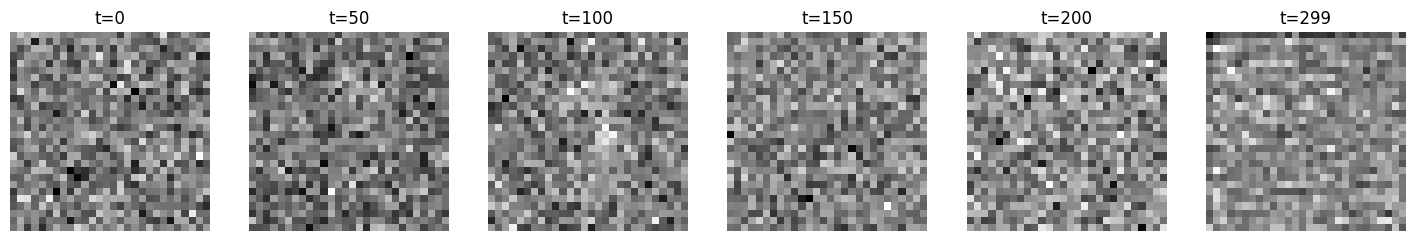

In [28]:

#INTERMEDIATE_VISUALIZATION

@torch.no_grad()
def visualize_denoising_steps(model, label, steps_to_show=[0, 50, 100, 150, 200, 299]):
    model.eval()
    img = torch.randn((1, 1, 28, 28), device=device)
    label_tensor = torch.tensor([label], device=device)
    label_embed = label_embedding(label_tensor)

    images = []

    for t in reversed(range(T)):
        t_tensor = torch.tensor([t], device=device)
        pred_noise = model(img, t_tensor, label_embed)
        alpha = alphas[t]
        img = (1 / alpha.sqrt()) * (img - ((1 - alpha).sqrt()) * pred_noise)

        if t in steps_to_show:
            images.append(img.squeeze().cpu().numpy())

        if t > 0:
            img += betas[t].sqrt() * torch.randn_like(img)

    # Plot selected steps
    fig, axs = plt.subplots(1, len(images), figsize=(18, 3))
    for i, im in enumerate(images):
        axs[i].imshow(im, cmap='gray')
        axs[i].set_title(f"t={steps_to_show[i]}")
        axs[i].axis('off')
    plt.show()

visualize_denoising_steps(model, label=7)
